In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.efficientnet import EfficientNetB3
from keras.applications.inception_v3 import InceptionV3

In [3]:
base_ds = 'datasets/final_ds'
base_ds = pathlib.Path(base_ds)

image_count = len(list(base_ds.glob('*/*.jpg')))
print(image_count)

23225


In [5]:
splitfolders.ratio(base_ds, output='finalds_splitted', seed=123, ratio=(.8,.1,.1), group_prefix=None)

Copying files: 23388 files [00:58, 398.12 files/s]


In [4]:
batch_size = 64
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)

In [5]:
train_datagen = ImageDataGenerator(
    shear_range = 0.2, 
    zoom_range = 0.2)

val_datagen = ImageDataGenerator()

train_ds = train_datagen.flow_from_directory(
    'datasets/finalds_splitted/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical')

val_ds = val_datagen.flow_from_directory(
    'datasets/finalds_splitted/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical',
    shuffle=False)

test_ds = val_datagen.flow_from_directory(
    'datasets/finalds_splitted/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical',
    shuffle=False)


Found 18568 images belonging to 8 classes.
Found 2325 images belonging to 8 classes.
Found 2332 images belonging to 8 classes.


In [6]:
inputs = tf.keras.Input(input_shape)
efficientnet = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights='imagenet', input_tensor=inputs )
efficientnet.trainable = False
x = efficientnet(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)
model_efficientnet = tf.keras.Model(inputs, x)

In [13]:
model_efficientnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_efficientnet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                             

In [14]:
checkpointer = ModelCheckpoint(filepath='finalds2_models/model_efficientnetv2.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [47]:
history1 = model_efficientnet.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
291/291 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.8835
Epoch 1: val_accuracy improved from -inf to 0.94409, saving model to finalds2_models\model_efficientnetv2.hdf5
291/291 [==============================] - 137s 453ms/step - loss: 0.3549 - accuracy: 0.8835 - val_loss: 0.1999 - val_accuracy: 0.9441 - lr: 0.0010
Epoch 2/100
291/291 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9473
Epoch 2: val_accuracy improved from 0.94409 to 0.96043, saving model to finalds2_models\model_efficientnetv2.hdf5
291/291 [==============================] - 87s 299ms/step - loss: 0.1692 - accuracy: 0.9473 - val_loss: 0.1349 - val_accuracy: 0.9604 - lr: 0.0010
Epoch 3/100
291/291 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9554
Epoch 3: val_accuracy did not improve from 0.96043
291/291 [==============================] - 86s 296ms/step - loss: 0.1503 - accuracy: 0.9554 - val_loss: 0.1774 - val_accuracy: 0.9523 - lr

Epoch 25: early stopping


In [48]:
model_efficientnet.load_weights('finalds2_models/model_efficientnetv2.hdf5')

In [7]:
efficientnet.trainable = True

model_efficientnet.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
history2 = model_efficientnet.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
291/291 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9969
Epoch 1: val_accuracy did not improve from 0.99441
291/291 [==============================] - 95s 304ms/step - loss: 0.0090 - accuracy: 0.9969 - val_loss: 0.0290 - val_accuracy: 0.9923 - lr: 1.0000e-05
Epoch 2/100
291/291 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9980
Epoch 2: val_accuracy did not improve from 0.99441
291/291 [==============================] - 87s 298ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0235 - val_accuracy: 0.9940 - lr: 1.0000e-05
Epoch 3/100
291/291 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9983
Epoch 3: val_accuracy improved from 0.99441 to 0.99699, saving model to finalds2_models\model_efficientnetv2.hdf5
291/291 [==============================] - 88s 301ms/step - loss: 0.0063 - accuracy: 0.9983 - val_loss: 0.0198 - val_accuracy: 0.9970 - lr: 1.0000e-05
Epoch 4/100
291/291 [===================

In [8]:
model_efficientnet.load_weights('models/finalds2_models/model_efficientnetv2.hdf5')

In [9]:
score1 = model_efficientnet.evaluate(val_ds, verbose=1)

37/37 [==============================] - 10s 175ms/step - loss: 0.0155 - accuracy: 0.9978


In [10]:
score2 = model_efficientnet.evaluate(test_ds, verbose=1)

37/37 [==============================] - 7s 175ms/step - loss: 0.0057 - accuracy: 0.9987


In [56]:
test_ds = val_datagen.flow_from_directory(
    'datasets/cockpit_ds',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical',
    shuffle=False)

Found 4318 images belonging to 8 classes.


In [57]:
score3 = model_efficientnet.evaluate(test_ds, verbose=1)

68/68 [==============================] - 19s 269ms/step - loss: 0.0068 - accuracy: 0.9995


In [58]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model_efficientnet.predict(test_ds)

In [12]:
test_ds.class_indices = ['safe driving', 'texting-right', 'calling-right', 'texting-left', 'calling-left', 'operating radio', 'drinking', 'reaching behind']
classes = ['safe driving', 'texting-right', 'calling-right', 'texting-left', 'calling-left', 'operating radio', 'drinking', 'reaching behind']

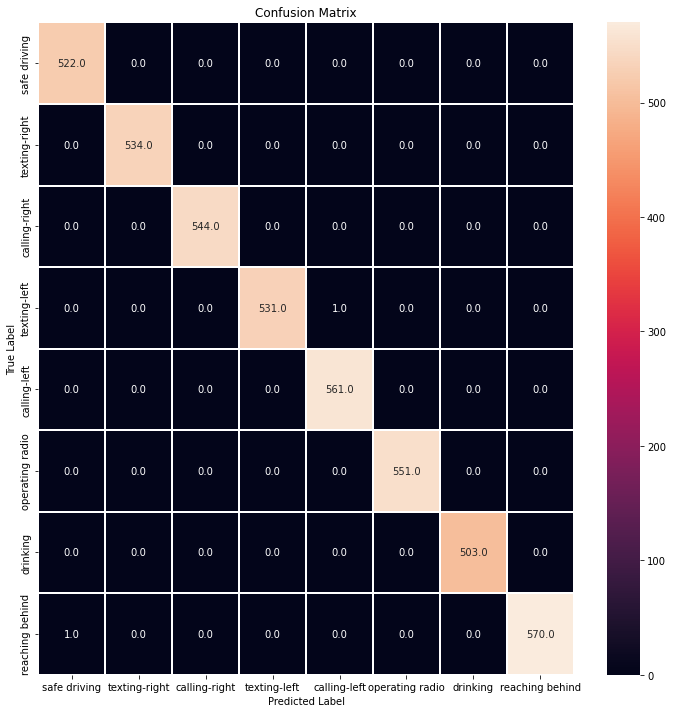

In [60]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(classes)
plt.title("Confusion Matrix")
plt.show()

In [61]:
report1 = classification_report(test_ds.classes, y_pred, target_names=classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
safe driving,1.000000,0.998088,0.999043,523.000000
texting-right,1.000000,1.000000,1.000000,534.000000
calling-right,1.000000,1.000000,1.000000,544.000000
texting-left,0.998120,1.000000,0.999059,531.000000
calling-left,1.000000,0.998221,0.999110,562.000000
operating radio,1.000000,1.000000,1.000000,551.000000
drinking,1.000000,1.000000,1.000000,503.000000
reaching behind,0.998249,1.000000,0.999124,570.000000
accuracy,0.999537,0.999537,0.999537,0.999537
macro avg,0.999546,0.999539,0.999542,4318.000000


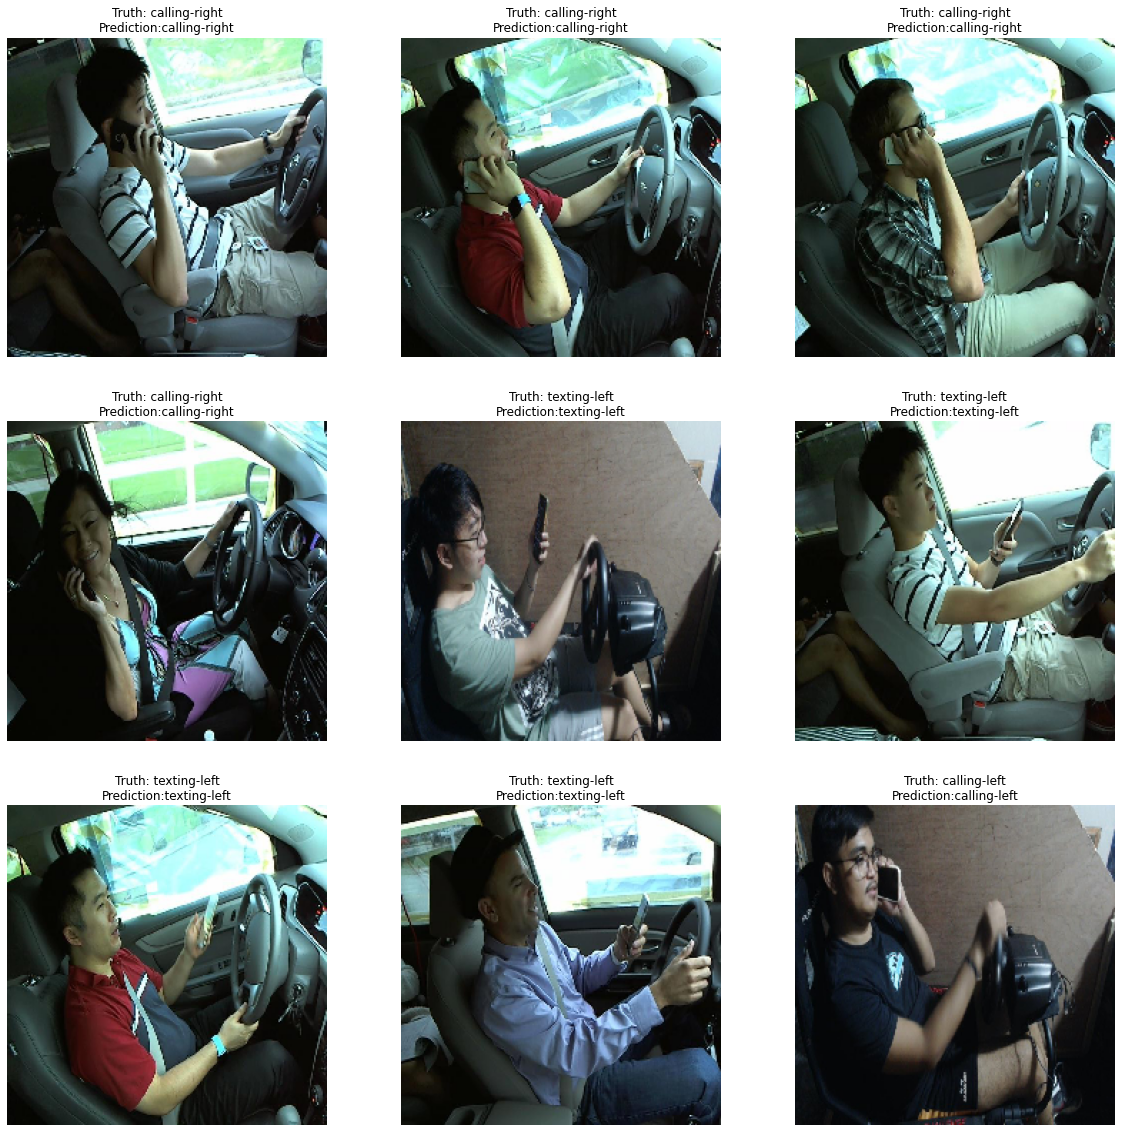

In [14]:
plt.figure(figsize=(20, 20))
for i in range(9):
    x, label= test_ds.next()
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i].astype('uint8'))
    result = np.where(label[i]==1)
    predict = model_efficientnet(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = classes[np.argmax(score)]
    plt.title(f'Truth: {classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)